In [1]:
!pip install matplotlib pandas torch torchmetrics scikit-learn

In [24]:
# Matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
# Numpy
import numpy as np
# Pandas
import pandas as pd
# Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import Accuracy
from model import ResNet50 as model
import torch.optim as optim
from collections import OrderedDict

In [26]:
import pickle
from sklearn.model_selection import train_test_split
import os

In [28]:
class SequenceDataset(Dataset):
    def __init__(self, npy_file_paths, labels):
        """
        Args:
            npy_file_paths (list of str): List of file paths for .npy files containing the sequences.
            labels (list): List of labels corresponding to each sequence.
        """
        # Load the sequences and labels
        self.data = [torch.tensor(np.load(file_path)) for file_path in npy_file_paths]
        self.labels = torch.tensor(labels, dtype=torch.float)  # Convert the labels to a tensor

    def __len__(self):
        # Dataset contains as many samples as the number of npy files
        return len(self.data)

    def __getitem__(self, idx):
        # Return the sequence data and its corresponding label
        return self.data[idx], self.labels[idx].long()

# Example usage
npy_file_paths = []
labels = []

root_dir = '../data/mel'
languages = sorted([d for d in os.listdir(root_dir) if d != '.ipynb_checkpoints' and os.path.isdir(os.path.join(root_dir, d))])
print(languages)
num_languages = len(languages)

for i, lang_dir in enumerate(languages):
    lang_path = os.path.join(root_dir, lang_dir)
    if not os.path.isdir(lang_path):
        continue  # Skip non-directory files

    # List all .npy files
    file_names = os.listdir(lang_path)
    full_paths = [os.path.join(lang_path, f) for f in file_names]

    # Extend lists
    npy_file_paths.extend(full_paths)
    labels.extend([i] * len(full_paths))


dataset = SequenceDataset(npy_file_paths, labels)

# dataloader = DataLoader(dataset, batch_size=64)

['chinese', 'english', 'indo', 'malay']


In [30]:
def split_data(dataset):
    # Split dataset into train, validation, and test sets
    train_data, temp_data = train_test_split(dataset, test_size=0.3, shuffle=True)
    valid_data, test_data = train_test_split(temp_data, test_size=0.5, shuffle=True)

    # Define batch size for training, full batch for validation and testing
    batch_size = 128

    # Create DataLoader objects
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)  # Mini-batch for training
    valid_loader = DataLoader(valid_data, batch_size=len(valid_data), shuffle=False)  # Full batch for validation
    test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)  # Full batch for testing

    return train_loader, valid_loader, test_loader

In [32]:
train_loader, valid_loader, test_loader = split_data(dataset)

In [34]:
class Trainer:
    def __init__(self, model, train_loader, valid_loader, test_loader, num_epochs=10, gradual_unfreezing=False, unfreeze_epochs=[]):
        self.device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.test_loader = test_loader
        self.num_epochs = num_epochs
        self.gradual_unfreezing = gradual_unfreezing
        self.unfreeze_epochs = (
            [] if unfreeze_epochs is None or not gradual_unfreezing 
            else sorted(unfreeze_epochs, reverse=True)  # Unfreeze last layers first
        )
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08)
        self.optimizer.zero_grad()
        self.accuracy_metric = Accuracy(task="multiclass", num_classes=self.model.num_classes).to(self.device)
        self.best_val_loss = float('inf')
        self.best_model_state = None
        self.best_epoch = 0
        self.l2_lambda = 0.001
        self.layer_groups = self._group_layers()
        self._initialize_requires_grad()

        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def _group_layers(self):
        layer_dict = OrderedDict()
        for name, param in self.model.named_parameters():
            layer_name = name.split(".")[0]  # Extract top-level layer name
            if layer_name not in layer_dict:
                layer_dict[layer_name] = []
            layer_dict[layer_name].append(param)
        return list(layer_dict.items())  # List of (layer_name, parameters) tuples

    def _initialize_requires_grad(self):
        if not self.gradual_unfreezing:  # If gradual_unfreezing is False, make all parameters trainable
            for param in self.model.parameters():
                param.requires_grad = True
        else:
            for layer_name, params in self.layer_groups:
                for param in params:
                    param.requires_grad = False
            self._unfreeze_layer() #unfreeze fc layer

    def _unfreeze_layer_by_epoch(self, epoch):
        if epoch in self.unfreeze_epochs:
            self._unfreeze_layer()
    
    def _unfreeze_layer(self):
        if self.layer_groups:
            layer_name, params = self.layer_groups.pop()  # Unfreeze last remaining layer
            for param in params:
                param.requires_grad = True

    def train(self):
        for epoch in range(self.num_epochs):
            self.model.train()
            self._unfreeze_layer_by_epoch(epoch)
            for inputs, targets in self.train_loader:
                inputs, targets = inputs.float().to(self.device), targets.to(self.device)
                pred = self.model(inputs)
                print("train:", pred, targets)
                loss = self.criterion(pred, targets)
                
                # L2 Regularization
                l2_norm = sum(p.pow(2).sum() for p in self.model.parameters())
                loss += self.l2_lambda * l2_norm
                
                self.accuracy_metric.update(pred, targets)
                accuracy = self.accuracy_metric.compute()
                self.accuracy_metric.reset()
                
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
            
            val_loss, val_accuracy = self.validate()
            self.train_losses.append(loss.item())
            self.train_accuracies.append(accuracy.item())
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_accuracy.item())
            
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.best_model_state = self.model.state_dict()
                self.best_epoch = epoch + 1
                self._save_best_model()
            
            print(f'Epoch [{epoch+1}/{self.num_epochs}], Training Loss: {loss.item():.4f}, Training Accuracy: {accuracy.item():.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
        
        self._load_best_model()
        self.test()

    def validate(self):
        self.model.eval()
        with torch.no_grad():
            inputs, targets = next(iter(self.valid_loader))
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            pred = self.model(inputs)
            print("valid:", pred, targets)
            loss = self.criterion(pred, targets).item()
            self.accuracy_metric.update(pred, targets)
            accuracy = self.accuracy_metric.compute()
            self.accuracy_metric.reset()
        return loss, accuracy

    def test(self):
        self.model.eval()
        with torch.no_grad():
            inputs, targets = next(iter(self.test_loader))
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            pred = self.model(inputs)
            print("test:", pred, targets)
            loss = self.criterion(pred, targets).item()
            self.accuracy_metric.update(pred, targets)
            accuracy = self.accuracy_metric.compute()
            self.accuracy_metric.reset()
        print(f'Final Test Loss: {loss:.4f}, Final Test Accuracy: {accuracy:.4f}')

    def _save_best_model(self):
        with open("best_model.pkl", "wb") as f:
            pickle.dump({"model_state": self.best_model_state, "epoch": self.best_epoch, "val_loss": self.best_val_loss}, f)

    def _load_best_model(self):
        with open("best_model.pkl", "rb") as f:
            saved_data = pickle.load(f)
            self.model.load_state_dict(saved_data["model_state"])
            print(f"Best Model Achieved at Epoch: {saved_data['epoch']} with Validation Loss: {saved_data['val_loss']:.4f}")

    def plot_losses(self):
        plt.figure(figsize=(8, 5))
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss vs. Epoch')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_accuracies(self):
        plt.figure(figsize=(8, 5))
        plt.plot(self.train_accuracies, label='Train Accuracy')
        plt.plot(self.val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Accuracy vs. Epoch')
        plt.legend()
        plt.grid(True)
        plt.show()

train: tensor([[ 0.2829, -0.0444,  0.1229, -0.1653],
        [ 0.4717,  0.4944, -1.1335,  0.1135],
        [ 0.9179,  0.8011, -0.0655,  0.7408],
        [ 0.2829, -0.0444,  0.1229, -0.1653],
        [ 0.4555,  1.0605, -0.4940,  0.2628],
        [ 0.2829, -0.0444,  0.1229, -0.1653],
        [ 0.0837, -0.0643,  0.2461,  0.1696],
        [ 0.2829, -0.0444,  0.1229, -0.1653],
        [ 0.9731, -0.3857,  0.2444,  0.0596],
        [-0.1034,  0.6190,  0.1181,  0.0016],
        [ 0.1240,  0.2113, -0.2209, -0.3752]], grad_fn=<AddmmBackward0>) tensor([1, 0, 0, 3, 0, 2, 0, 0, 0, 0, 0])
valid: tensor([[ 213375.0469, -212015.4531, -218124.0000, -198104.7344],
        [ 211182.1406, -209855.2812, -215918.8125, -195953.9531]]) tensor([0, 0])
Epoch [1/10], Training Loss: 9.6106, Training Accuracy: 0.2727, Validation Loss: 0.0000, Validation Accuracy: 1.0000
train: tensor([[ 285.6826, -280.3760, -287.1945, -259.8596],
        [ 285.6826, -280.3760, -287.1945, -259.8596],
        [ 298.7427, -293.4521, 

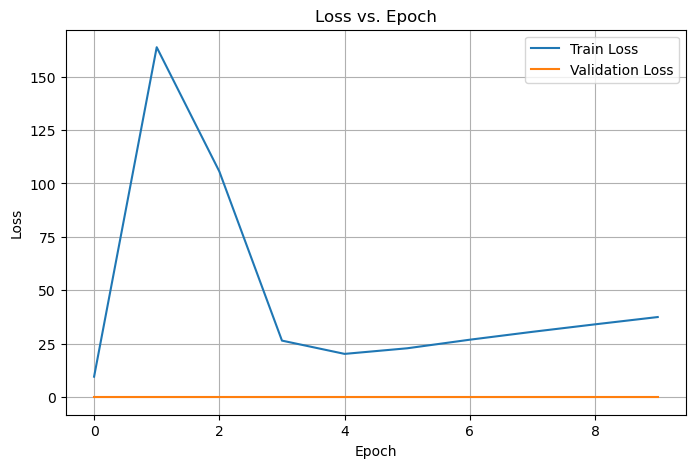

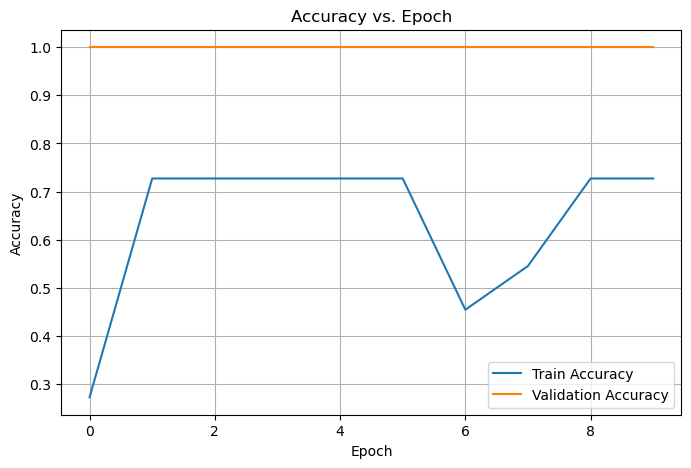

In [36]:
trainer = Trainer(model(num_classes=num_languages), train_loader, valid_loader, test_loader)
trainer.train()
trainer.plot_losses()
trainer.plot_accuracies()